- Cambiare il lavoro usando il wait time distribuito in maniera uniforme nella classe.

In [155]:
import pandas as pd
file_path = "OR_AE2_Project_Adjusted.xlsx"
df_original = pd.read_excel(file_path, engine='openpyxl')

### Preprocessing

Per prima cosa, estendiamo il dataset di tante righe quanti sono le osservazioni associate alla singola riga.

In [156]:
df = df_original.loc[df_original.index.repeat(df_original['Number_Of_Attendances'])].reset_index(drop=True)
df = df.drop(columns=['Number_Of_Attendances'])

Trasformiamo le variabili Wait_Time e Driving_Time_mins in variabili numeriche selezionando la loro media.

In [ ]:
range_mapping = {
    '00-29': 15,
    '30-59': 45,
    '60-89': 75,
    '90-119': 105,
    '120-149': 135,
    '150-179': 165,
    '180-209': 195,
    '210-239': 225,
    '240-269': 255,
    '270-299': 285,
    '300-329': 315,
    '360+': 375
}

# Define the mapping for 'Drive_Time_mins'
time_mapping = {
    '00 to 05': 2.5,
    '05 to 10': 7.5,
    '10 to 15': 12.5,
    '15 to 20': 17.5,
    '20 to 25': 22.5,
    '25 to 30': 27.5,
    '30 to 35': 32.5,
    '35 to 40': 37.5,
    '40 to 45': 42.5,
    '45 to 50': 47.5,
    '50 to 55': 52.5,
    '55 to 60': 57.5,
    '60 to 65': 62.5,
    '65 to 70': 67.5,
    '70 to 75': 72.5,
    '75 to 80': 77.5,
    '80 to 85': 82.5,
    '85 to 90': 87.5
}

# Apply the mappings to transform the columns into numerical values
df['Driving_Time_mins'] = df['Driving_Time_mins'].map(time_mapping)
df['Wait_Time'] = df['Wait_Time'].map(range_mapping)


### Divisione in Regioni

Per prima cosa, definiamo una nuova variabile "Total_Time" come la somma del wait_time e del driving_time

df['Total_Time'] = df['Wait_Time'] + df['Driving_Time_mins']
df.head()

Raggruppiamo il Total_Time a seconda del postcode di riferimento del paziente. In totale, otteniamo 91 righe associate a 91 punti del nostro dataset.

In [ ]:
total_time_per_pat = df.groupby(['Pat_X', 'Pat_Y'])['Total_Time'].sum().reset_index()
total_time_per_pat

,Pat_X,Pat_Y,Total_Time
0,85,97024,121285.0
1,231,108665,3497720.0
2,551,104275,1038350.0
3,2923,92120,195965.0
4,3394,125970,5893927.5
...,...,...,...
86,56754,114614,3474977.5
87,59585,104365,2454237.5
88,63912,99490,1522137.5
89,66780,91925,1596300.0


Visualizzazione dei postcodes

<Axes: xlabel='Pat_X', ylabel='Pat_Y'>

c:\Users\glauc\Desktop\Edimburgh challenge\Operational_A-E\.venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


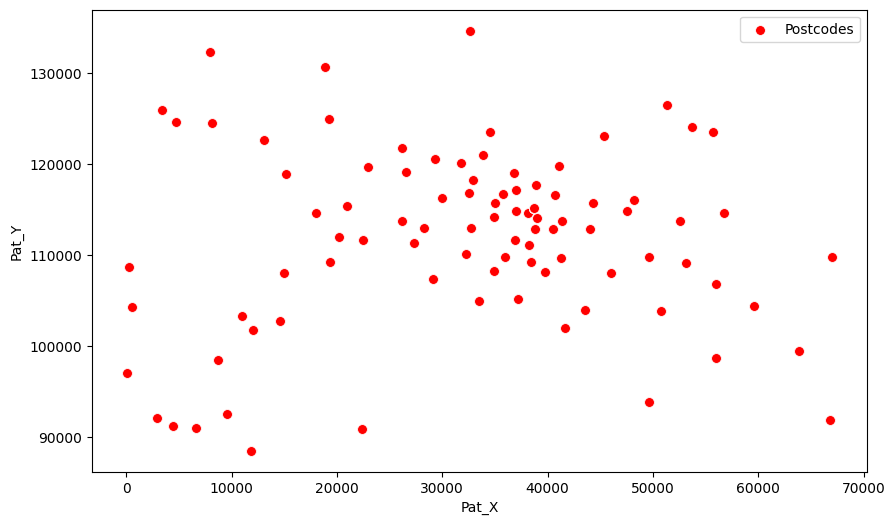

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatterplot di siti e postcodes
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Pat_X', y='Pat_Y', data=df, label='Postcodes', s=50, color='red')

Da questo codice, tiriamo fuori alcune nuove varibili. Dividiamo la regione in poligoni utilizzando una "mappa di Voronoi". La mappa viene divisa fra i punti usando come criterio la distanza euclidea. Ogni postcode fa sua una determinata regione e ne è centro. Salviamo queste regioni nella variabile finite_polygons e le loro aree in areas. 

A causa del fatto che la mappa non è circoscritta, alcuni poligoni sono infiniti, altri troppo grandi. Tagliamo quindi la mappa secondo un bounding_box arbitrario con 3000 di scarto in ogni direzione ed escludiamo i poligoni infiniti.

C:\Users\glauc\AppData\Local\Temp\ipykernel_5368\3582266922.py:41: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  poly_patch = Polygon(list(clipped_poly.exterior.coords), closed=True, color=color, alpha=0.5, edgecolor='black')
C:\Users\glauc\AppData\Local\Temp\ipykernel_5368\3582266922.py:41: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  poly_patch = Polygon(list(clipped_poly.exterior.coords), closed=True, color=color, alpha=0.5, edgecolor='black')
C:\Users\glauc\AppData\Local\Temp\ipykernel_5368\3582266922.py:41: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  poly_patch = Polygon(list(clipped_poly.exterior.coords), closed=True, color=color, alpha=0.5, edgecolor='black')
C:\Users\glauc\AppData\Local\Temp\ipykernel_5368\3582266922.py:41: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  poly_

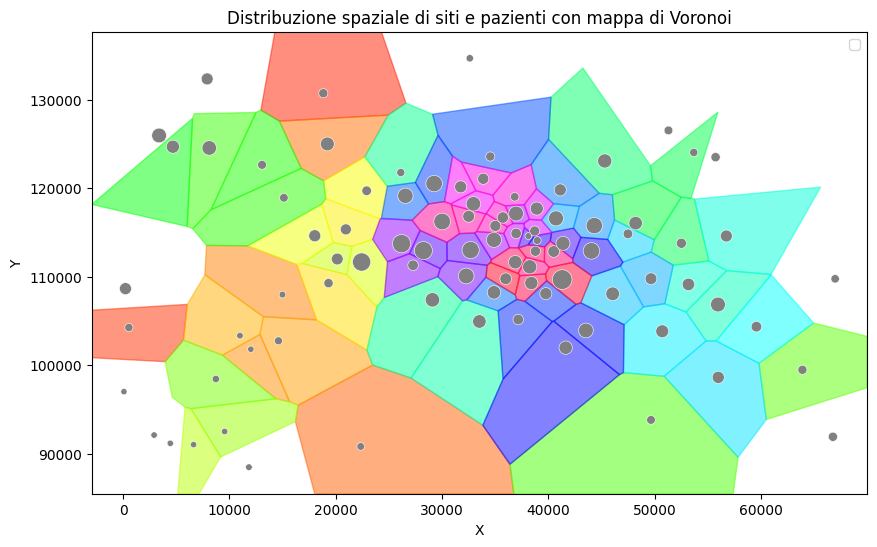

In [ ]:
from scipy.spatial import Voronoi
from matplotlib.patches import Polygon
from shapely.geometry import Polygon as ShapelyPolygon, box  

# Creazione della mappa di Voronoi utilizzando le coordinate dei postcodes
points = df[['Pat_X', 'Pat_Y']].values  # Coordinate dei postcodes
vor = Voronoi(points)  # Calcolo della mappa di Voronoi

# Salvataggio dei punti e delle aree finite
finite_polygons = []
areas = []

# Determina i limiti per il quadrato attorno ai postcodes
x_min, x_max = points[:, 0].min() - 3000, points[:, 0].max() + 3000
y_min, y_max = points[:, 1].min() - 3000, points[:, 1].max() + 3000

# Crea un poligono rettangolare con i limiti
bounding_box = box(x_min, y_min, x_max, y_max)

# Plot della mappa di Voronoi
fig, ax = plt.subplots(figsize=(10, 6))

# Genera una lista di colori casuali (1 per ogni regione di Voronoi)
num_regions = len(vor.regions)
colors = sns.color_palette("hsv", n_colors=num_regions)  # Usa una palette di colori distinta

for region_idx, region in enumerate(vor.regions):
    if len(region) > 0 and -1 not in region:  # Salta le regioni che vanno all'infinito
        polygon = [vor.vertices[i] for i in region]  # Ottiene i vertici del poligono
        if len(polygon) > 0:  # Se ci sono vertici validi
            # Calcolo del poligono Shapely e la sua intersezione con il bounding box
            poly_shapely = ShapelyPolygon(polygon)  # Crea un poligono Shapely
            if poly_shapely.is_valid:  # Verifica se il poligono è valido
                clipped_poly = poly_shapely.intersection(bounding_box)  # Intersezione con il bounding box
                if not clipped_poly.is_empty:  # Verifica che non sia vuoto
                    finite_polygons.append(clipped_poly)  # Salva il poligono ritagliato
                    poly_area = clipped_poly.area  # Calcola l'area
                    areas.append(poly_area)  # Salva l'area
                    # Disegno il poligono sulla mappa
                    color = colors[region_idx % len(colors)]  # Seleziona il colore dalla lista dei colori
                    poly_patch = Polygon(list(clipped_poly.exterior.coords), closed=True, color=color, alpha=0.5, edgecolor='black')
                    ax.add_patch(poly_patch)

# Aggiunta dei punti alla mappa di Voronoi
sns.scatterplot(
    x='Pat_X', 
    y='Pat_Y', 
    data=total_time_per_pat, 
    size='Total_Time',  # Colonna con il conteggio
    sizes=(20, 200),  # Gamma di dimensioni dei punti (min, max)
    color='grey', 
    legend=False,  # Non mostrare la legenda delle dimensioni
    ax=ax
)

# Imposta limiti del plot
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Imposta titolo, legenda e mostra il grafico
plt.title('Distribuzione spaziale di siti e pazienti con mappa di Voronoi')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

### Trovare la posizione migliore per creare un nuovo sito

Per prima cosa, creiamo una nuova variabile total_time_per_pat['Num_Points'] che serve a contenere il numero di punti che intendiamo simulare in ogni regione di riferimento. In ogni regione simuliamo tanti punti quanto è il total_time associato a quel postcode. Non ci interessa quanti pazienti hanno fatto richiesta di aiuto, né quanti GPs ci sono. Quello che ci interessa è quanto effettivamente queste persone aspettano. Se aspettano tanto, hanno più bisogno di aiuto. E se sono tanti che aspettano tanto, allora il Total_time lieviterà. Quindi aumentermo il numero di punti (Num_Points) simulati in quella regione.

In [ ]:
# Calcolare la somma totale del tempo
total_time_sum = total_time_per_pat['Total_Time'].sum()

# Calcolare il numero di punti come intero troncato
total_time_per_pat['Num_Points'] = ((total_time_per_pat['Total_Time'] / total_time_sum) * 10000).astype(int)

total_time_per_pat[['Pat_X', 'Pat_Y', 'Total_Time', 'Num_Points']].head()

,Pat_X,Pat_Y,Total_Time,Num_Points
0,85,97024,121285.0,3
1,231,108665,3497720.0,109
2,551,104275,1038350.0,32
3,2923,92120,195965.0,6
4,3394,125970,5893927.5,184


In [ ]:
import pickle

# Salvataggio delle variabili in un file binario
with open('data/voronoi_data.pkl', 'wb') as f:
    pickle.dump({'finite_polygons': finite_polygons, 'areas': areas, 'total_time_per_pat': total_time_per_pat}, f)

In [ ]:
# Caricamento delle variabili dal file binario
with open('data/voronoi_data.pkl', 'rb') as f:
    data = pickle.load(f)
    finite_polygons = data['finite_polygons']
    areas = data['areas']
    total_time_per_pat = data['total_time_per_pat']

Quali punti non sono all'interno di alcun poligono? Ci serve saperlo per poterli aggiungere singolarmente all'interno della mappa di punti simulata

In [ ]:
from shapely.geometry import Point

# Lista per salvare le righe che non sono dentro i poligoni
out_of_polygons = []

# Per ogni riga di total_time_per_pat, crea un punto e verifica se è dentro uno dei poligoni
for _, row in total_time_per_pat.iterrows():
    point = Point(row['Pat_X'], row['Pat_Y'])  # Crea il punto
    inside_polygon = False
    
    # Verifica se il punto è dentro uno dei poligoni
    for polygon in finite_polygons:
        if polygon.contains(point):  # Se il punto è dentro il poligono
            inside_polygon = True
            break
    
    if not inside_polygon:  # Se il punto non è dentro nessun poligono
        out_of_polygons.append(row)  # Salva la riga

# Converte la lista in un DataFrame
out_of_polygons_df = pd.DataFrame(out_of_polygons)

# Assicurati che la colonna 'Num_Points' sia un intero
out_of_polygons_df['Num_Points'] = out_of_polygons_df['Num_Points'].astype(int)
out_of_polygons_df['Pat_X'] = out_of_polygons_df['Pat_X'].astype(int)
out_of_polygons_df['Pat_Y'] = out_of_polygons_df['Pat_Y'].astype(int)
out_of_polygons_df['Total_Time'] = out_of_polygons_df['Total_Time'].astype(int)

# Mostra le righe fuori dai poligoni
print(out_of_polygons_df)

    Pat_X   Pat_Y  Total_Time  Num_Points
0      85   97024      121285           3
1     231  108665     3497720         109
3    2923   92120      195965           6
4    3394  125970     5893927         184
5    4449   91186      167620           5
8    7917  132362     3456592         107
13  11844   88491      283402           8
39  32623  134695      615680          19
79  51311  126545     1321770          41
83  55742  123521     1619002          50
89  66780   91925     1596300          49
90  66989  109774     1139382          35


C:\Users\glauc\AppData\Local\Temp\ipykernel_5368\3690627150.py:14: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  poly_patch = Polygon(list(polygon.exterior.coords), closed=True, color=color, alpha=0.5, edgecolor='black')
C:\Users\glauc\AppData\Local\Temp\ipykernel_5368\3690627150.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


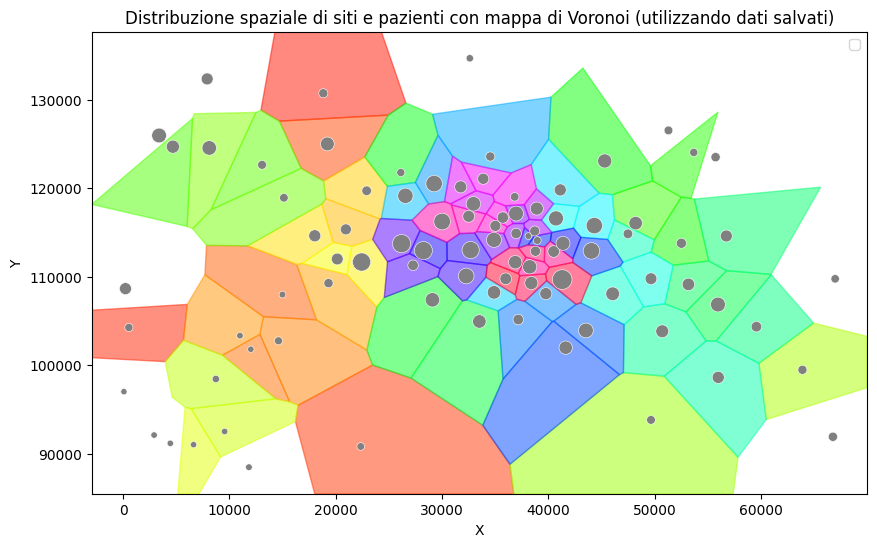

In [ ]:
from matplotlib.patches import Polygon

# Plot della mappa di Voronoi utilizzando i dati salvati
fig, ax = plt.subplots(figsize=(10, 6))

# Genera una lista di colori casuali (1 per ogni regione di Voronoi)
num_regions = len(finite_polygons)
colors = sns.color_palette("hsv", n_colors=num_regions)  # Usa una palette di colori distinta

for region_idx, polygon in enumerate(finite_polygons):
    if not polygon.is_empty:  # Verifica se il poligono non è vuoto
        # Disegno il poligono sulla mappa
        color = colors[region_idx % len(colors)]  # Seleziona il colore dalla lista dei colori
        poly_patch = Polygon(list(polygon.exterior.coords), closed=True, color=color, alpha=0.5, edgecolor='black')
        ax.add_patch(poly_patch)

# Aggiunta dei punti alla mappa di Voronoi
sns.scatterplot(
    x='Pat_X', 
    y='Pat_Y', 
    data=total_time_per_pat, 
    size='Total_Time',  # Colonna con il conteggio
    sizes=(20, 200),  # Gamma di dimensioni dei punti (min, max)
    color='grey', 
    legend=False,  # Non mostrare la legenda delle dimensioni
    ax=ax
)

# Imposta limiti del plot
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Imposta titolo, legenda e mostra il grafico
plt.title('Distribuzione spaziale di siti e pazienti con mappa di Voronoi (utilizzando dati salvati)')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


In [ ]:
import numpy as np
from shapely.geometry import Point, Polygon

# Funzione per generare punti uniformemente distribuiti all'interno di un poligono
def generate_random_points_in_polygon(polygon, num_points):
    # Calcolare i limiti del poligono (bounding box)
    min_x, min_y, max_x, max_y = polygon.bounds
    
    points = []
    while len(points) < num_points:
        # Genera un punto casuale all'interno dei limiti
        random_point = Point(np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
        
        # Verifica se il punto è all'interno del poligono
        if polygon.contains(random_point):
            points.append(random_point)
    
    return points

# Lista per salvare i punti generati
all_generated_points = []

# Iterare su ogni area di Voronoi e generare punti in base a Num_Points
for idx, polygon in enumerate(finite_polygons):
    num_points = total_time_per_pat.iloc[idx]['Num_Points']  # Numero di punti da generare
    shapely_polygon = Polygon(polygon)  # Crea un poligono Shapely
    generated_points = generate_random_points_in_polygon(shapely_polygon, num_points)
    
    # Aggiungere i punti generati alla lista
    all_generated_points.extend(generated_points)

# Converti i punti generati in un DataFrame
generated_points_df = pd.DataFrame({
    'X': [point.x for point in all_generated_points],
    'Y': [point.y for point in all_generated_points]
})


In [ ]:
import pandas as pd

# Lista per salvare i punti generati
generated_points_list = []

# Aggiungere le righe di out_of_polygons_df a generated_points_df
for _, row in out_of_polygons_df.iterrows():
    num_points = row['Num_Points']
    # Aggiungere 'num_points' righe con le coordinate del punto
    for _ in range(num_points):
        new_row = pd.DataFrame({
            'X': [row['Pat_X']],
            'Y': [row['Pat_Y']]
        })
        generated_points_list.append(new_row)

# Concatena tutte le righe in un unico DataFrame
new_points_df = pd.concat(generated_points_list, ignore_index=True)

# Concatena new_points_df a generated_points_df
generated_points_df = pd.concat([generated_points_df, new_points_df], ignore_index=True)

# Mostra il DataFrame risultante
print(generated_points_df)


                 X              Y
0     14812.062799  127893.155832
1     14704.137562  137513.298240
2     19696.689802  130829.896416
3       146.431070  104887.148793
4     -1548.624425  103782.502266
...            ...            ...
9639  66989.000000  109774.000000
9640  66989.000000  109774.000000
9641  66989.000000  109774.000000
9642  66989.000000  109774.000000
9643  66989.000000  109774.000000

[9644 rows x 2 columns]


C:\Users\glauc\AppData\Local\Temp\ipykernel_5368\2543370118.py:13: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  poly_patch = mpl_polygon(list(polygon.exterior.coords), closed=True, color=color, alpha=0.5, edgecolor='black')


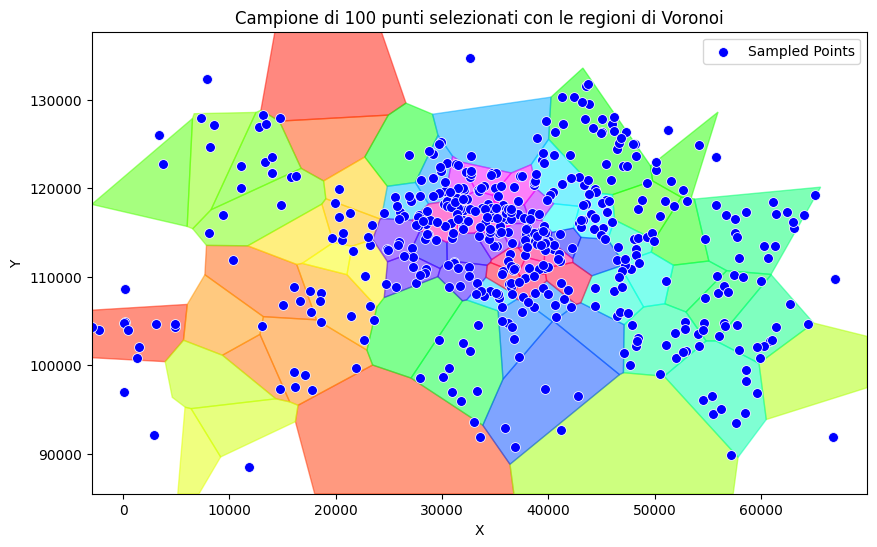

In [ ]:
from matplotlib.patches import Polygon as mpl_polygon

sample_points = generated_points_df.sample(n=500, random_state=42)

# Plot della mappa di Voronoi con le regioni per ogni postcode
fig, ax = plt.subplots(figsize=(10, 6))

# Aggiungi i poligoni di Voronoi
for region_idx, polygon in enumerate(finite_polygons):
    if not polygon.is_empty:  # Verifica che il poligono non sia vuoto
        color = colors[region_idx % len(colors)]
        # Crea il poligono utilizzando Polygon da Matplotlib
        poly_patch = mpl_polygon(list(polygon.exterior.coords), closed=True, color=color, alpha=0.5, edgecolor='black')
        ax.add_patch(poly_patch)

# Aggiungi i punti selezionati al campione
sns.scatterplot(x='X', y='Y', data=sample_points, color='blue', s=50, ax=ax, label='Sampled Points')

# Aggiungi i punti originali generati (opzionale, per riferimento)
#sns.scatterplot(x='X', y='Y', data=generated_points_df, color='red', s=10, ax=ax)

# Imposta i limiti del plot
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Imposta titolo e etichette
plt.title('Campione di 100 punti selezionati con le regioni di Voronoi')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

# Mostra il grafico
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

# Supponiamo che df contenga le colonne 'Site_X' e 'Site_Y' per i siti
# e che generated_points_df contenga le colonne 'X' e 'Y' per i punti generati

# 1. Calcolare la distanza euclidea tra ogni punto in generated_points_df e i punti unici di Site_X e Site_Y
unique_sites = df[['Site_X', 'Site_Y']].drop_duplicates().values
points = generated_points_df[['X', 'Y']].values

# Calcolare la matrice delle distanze euclidee
distances = cdist(points, unique_sites, metric='euclidean')

# 2. Associare ogni punto al sito che ha la distanza minima
min_dist_indices = np.argmin(distances, axis=1)
generated_points_df['Assigned_Site'] = min_dist_indices

# 3. Sommare le distanze euclidee per ogni sito
total_dist_per_site = pd.DataFrame({'Site': np.arange(len(unique_sites)), 'Total_Dist': np.zeros(len(unique_sites))})

for i, site_idx in enumerate(min_dist_indices):
    total_dist_per_site.loc[site_idx, 'Total_Dist'] += distances[i, site_idx]

# 4. Calcolare la somma totale delle distanze (total_dist)
total_dist = total_dist_per_site['Total_Dist'].sum()

print(total_dist)

55710845.15823345


In [ ]:
# 5. Trovare il nuovo sito che riduce al massimo la distanza totale
# Proveremo ad aggiungere un sito in una posizione casuale e calcolare il miglior sito

def calculate_total_dist_with_new_site(new_site, points, unique_sites, min_dist_indices):
    # Calcolare le distanze con il nuovo sito
    extended_sites = np.vstack([unique_sites, new_site])
    distances_with_new_site = cdist(points, extended_sites, metric='euclidean')
    
    # Associare ogni punto al sito con la distanza minima (incluso il nuovo sito)
    new_min_dist_indices = np.argmin(distances_with_new_site, axis=1)
    
    # Calcolare la somma delle distanze totali per tutti i siti, inclusi quelli nuovi
    total_dist_with_new_site = np.zeros(len(extended_sites))
    for i, site_idx in enumerate(new_min_dist_indices):
        total_dist_with_new_site[site_idx] += distances_with_new_site[i, site_idx]
    
    return total_dist_with_new_site.sum()


In [220]:
from matplotlib.patches import Polygon as mpl_polygon

# Funzione per calcolare la distanza totale con un nuovo sito
def calculate_total_dist_with_new_site(new_site, points, unique_sites, min_dist_indices):
    # Aggiungi il nuovo sito
    all_sites = np.vstack([unique_sites, new_site])
    
    # Calcola la distanza per ogni punto dalla nuova posizione
    total_dist = 0
    for i, point in enumerate(points):
        min_dist = np.min(np.linalg.norm(all_sites - point, axis=1))  # Distanza dal punto al sito più vicino
        total_dist += min_dist
    return total_dist

# Imposta la griglia di punti da provare
num_points_per_axis = 200  # Numero di punti per asse (maggiore è il numero, più fine è la griglia)
x_grid = np.linspace(x_min, x_max, num_points_per_axis)
y_grid = np.linspace(y_min, y_max, num_points_per_axis)

# Proviamo a generare nuovi siti in posizioni sulla griglia e selezionare quello che minimizza la distanza totale
best_new_site = None
min_total_dist = total_dist

# Contatore di iterazioni
iteration = 0
total_iterations = len(x_grid) * len(y_grid)

# Esplora tutte le posizioni sulla griglia
for x_idx, x in enumerate(x_grid):
    for y_idx, y in enumerate(y_grid):
        new_site_candidate = np.array([[x, y]])  # Candidato per il nuovo sito
        
        new_total_dist = calculate_total_dist_with_new_site(new_site_candidate, points, unique_sites, min_dist_indices)
        
        if new_total_dist < min_total_dist:
            best_new_site = new_site_candidate
            min_total_dist = new_total_dist
        
        iteration += 1

        # Stampa il messaggio di avanzamento ogni 1000 iterazioni
        if iteration % 2000 == 0 or iteration == total_iterations:
            print(f"Iterazione {iteration}/{total_iterations} - Migliore distanza totale: {min_total_dist:.4f}, Location: {best_new_site}")
            
print(f"\nBest new site: {best_new_site}")
print(f"New total distance: {min_total_dist}")

Iterazione 2000/40000 - Migliore distanza totale: 50727538.8550, Location: [[   382.16582915 105952.86934673]]
Iterazione 4000/40000 - Migliore distanza totale: 50218282.1863, Location: [[  4045.68341709 105165.87437186]]
Iterazione 6000/40000 - Migliore distanza totale: 49961002.3670, Location: [[  7709.20100503 105165.87437186]]
Iterazione 8000/40000 - Migliore distanza totale: 49860882.9517, Location: [[ 10640.01507538 105428.20603015]]
Iterazione 10000/40000 - Migliore distanza totale: 49860882.9517, Location: [[ 10640.01507538 105428.20603015]]
Iterazione 12000/40000 - Migliore distanza totale: 49860882.9517, Location: [[ 10640.01507538 105428.20603015]]
Iterazione 14000/40000 - Migliore distanza totale: 49860882.9517, Location: [[ 10640.01507538 105428.20603015]]
Iterazione 16000/40000 - Migliore distanza totale: 49860882.9517, Location: [[ 10640.01507538 105428.20603015]]
Iterazione 18000/40000 - Migliore distanza totale: 49860882.9517, Location: [[ 10640.01507538 105428.2060301

In [221]:
np.savez('data/best_site_data2.npz', best_new_site=best_new_site, min_total_dist=min_total_dist)
print("Variabili 'best_new_site' e 'min_total_dist' salvate con successo in 'best_site_data2.npz'")

Variabili 'best_new_site' e 'min_total_dist' salvate con successo in 'best_site_data2.npz'


In [222]:
# Carica le variabili best_new_site e min_total_dist dal file .npz
data = np.load('data/best_site_data2.npz')
best_new_site = data['best_new_site']
min_total_dist = data['min_total_dist']

print(f"Variabili ricaricate con successo:\n- Best New Site: {best_new_site}\n- Min Total Dist: {min_total_dist}")

Variabili ricaricate con successo:
- Best New Site: [[ 10640.01507538 105428.20603015]]
- Min Total Dist: 49860882.951653585


C:\Users\glauc\AppData\Local\Temp\ipykernel_5368\3680680686.py:17: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  poly_patch = mpl_polygon(list(polygon.exterior.coords), color=color, alpha=0.5, edgecolor='black')
c:\Users\glauc\Desktop\Edimburgh challenge\Operational_A-E\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


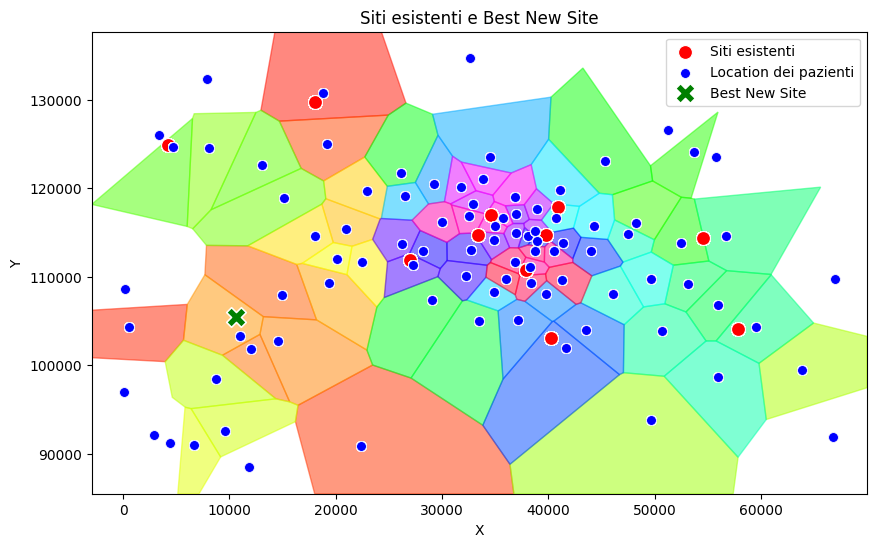

In [234]:
from matplotlib.patches import Polygon as mpl_polygon

# Crea un DataFrame temporaneo per il Best New Site
best_new_site_df = pd.DataFrame({
    'Site_X': [best_new_site[0][0]],  # Coordinata X del Best New Site
    'Site_Y': [best_new_site[0][1]]   # Coordinata Y del Best New Site
})

# Crea il plot
fig, ax = plt.subplots(figsize=(10, 6))

# Aggiungi i poligoni di Voronoi per i siti esistenti
for region_idx, polygon in enumerate(finite_polygons):
    if not polygon.is_empty:  # Usa il metodo is_empty per verificare se il poligono è vuoto
        color = colors[region_idx % len(colors)]
        # Crea il poligono utilizzando Polygon da Matplotlib, passando le coordinate
        poly_patch = mpl_polygon(list(polygon.exterior.coords), color=color, alpha=0.5, edgecolor='black')
        ax.add_patch(poly_patch)

# Aggiungi i siti esistenti
sns.scatterplot(x='Site_X', y='Site_Y', data=df, color='red', s=100, ax=ax, label='Siti esistenti')

#Aggiungi i postcodes
sns.scatterplot(x='Pat_X', y='Pat_Y', data=df, color='blue', s=50, ax=ax, label='Location dei pazienti')

# Aggiungi il Best New Site (ottimizzato)
sns.scatterplot(x='Site_X', y='Site_Y', data=best_new_site_df, color='green', s=200, ax=ax, label='Best New Site', marker='X')

# Impostazioni del plot
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plt.title('Siti esistenti e Best New Site')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

# Mostra il grafico
plt.show()


In [235]:
# Aggiungi il Best New Site all'elenco dei siti esistenti
all_sites = np.vstack([unique_sites, best_new_site])

# Per ogni punto, trova il sito più vicino e conta quanti punti sono associati a ciascun sito
site_point_counts = {f"Site_{i}": 0 for i in range(len(all_sites))}

for i, point in enumerate(points):
    distances = np.linalg.norm(all_sites - point, axis=1)  # Calcola le distanze di un punto a tutti i siti
    closest_site_index = np.argmin(distances)  # Trova l'indice del sito più vicino
    site_point_counts[f"Site_{closest_site_index}"] += 1  # Incrementa il conteggio del sito corrispondente

# Stampa il numero di punti associati a ciascun sito
print("\n--- Numero di punti associati a ciascun sito ---")
for site_idx, (site_name, point_count) in enumerate(site_point_counts.items()):
    site_coordinates = all_sites[site_idx]
    print(f"{site_name} (X={site_coordinates[0]:.2f}, Y={site_coordinates[1]:.2f}) -> {point_count} punti")


--- Numero di punti associati a ciascun sito ---
Site_0 (X=39785.00, Y=114688.00) -> 817 punti
Site_1 (X=37920.00, Y=110782.00) -> 971 punti
Site_2 (X=40877.00, Y=117868.00) -> 973 punti
Site_3 (X=34629.00, Y=117035.00) -> 1460 punti
Site_4 (X=33369.00, Y=114746.00) -> 556 punti
Site_5 (X=4258.00, Y=124892.00) -> 536 punti
Site_6 (X=27024.00, Y=111909.00) -> 840 punti
Site_7 (X=40269.00, Y=103066.00) -> 853 punti
Site_8 (X=54562.00, Y=114442.00) -> 835 punti
Site_9 (X=57894.00, Y=104081.00) -> 912 punti
Site_10 (X=18043.00, Y=129799.00) -> 184 punti
Site_11 (X=10640.02, Y=105428.21) -> 707 punti


In [241]:
print(f"Da solo, il nuovo sito sarebbe il punto di riferimento per il {707/96} per cento della domanda presente negli altri 91 siti")

Da solo, il nuovo sito sarebbe il punto di riferimento per il 7.364583333333333 per cento della domanda presente negli altri 91 siti


C:\Users\glauc\AppData\Local\Temp\ipykernel_5368\2932927629.py:40: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
C:\Users\glauc\AppData\Local\Temp\ipykernel_5368\2932927629.py:40: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
C:\Users\glauc\AppData\Local\Temp\ipykernel_5368\2932927629.py:40: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
C:\Users\glauc\AppData\Local\Temp\ipykernel_5368\2932927629.py:40: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
C:\Users\glauc\AppData\Local\Temp\ipykernel_5368\2932927629.py:40: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
C:\Users\glauc\AppData\Local\Temp\ipykernel_5368\2932927629.py:40: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
C:\Users\glauc\AppData

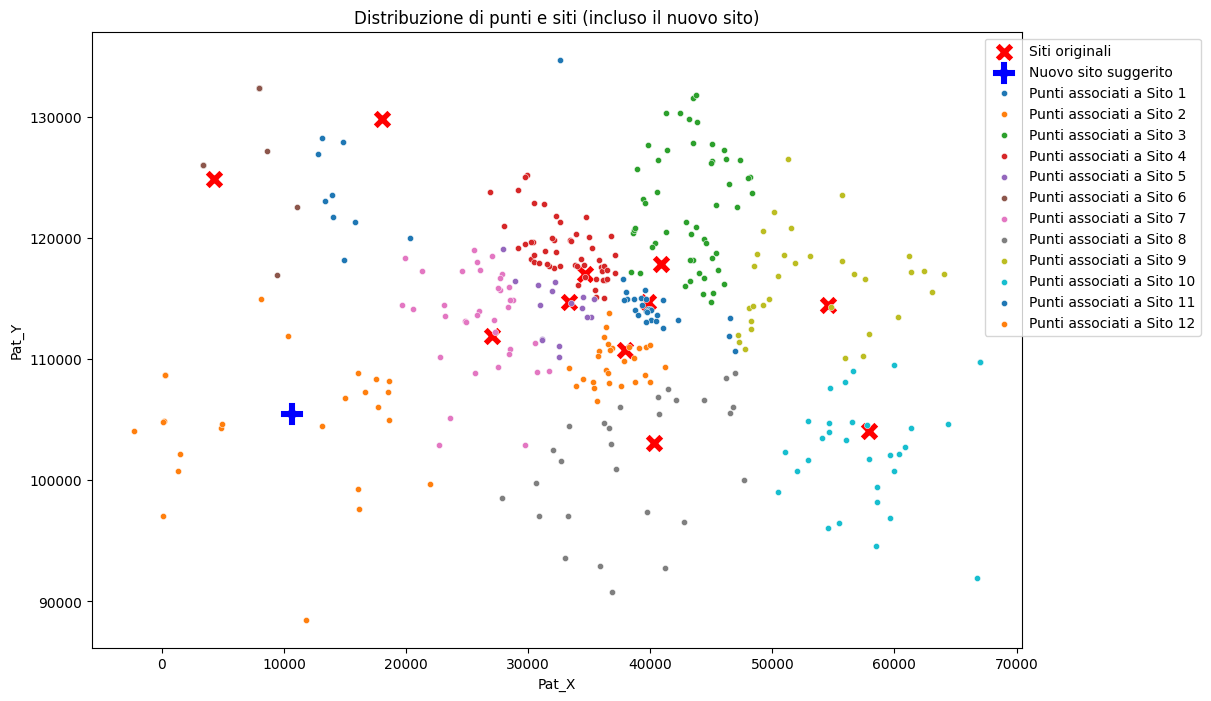

In [242]:
from scipy.spatial import distance_matrix

all_sites = np.vstack([unique_sites, best_new_site])

# Seleziona un sample casuale di 1000 punti dal DataFrame di punti generati
sample_points = generated_points_df.sample(n=350, random_state=42)[['X', 'Y']].values

# Calcola la distanza di ciascun punto del campione a ogni sito (incluso il best_new_site)
dist_matrix = distance_matrix(sample_points, all_sites)

# Assegna a ogni punto il sito più vicino
assigned_sites = dist_matrix.argmin(axis=1)

# Plot della mappa
fig, ax = plt.subplots(figsize=(12, 8))

# Plotta i siti esistenti (escluso il best new site)
sns.scatterplot(
    x=unique_sites[:, 0], 
    y=unique_sites[:, 1], 
    color='red', 
    s=200, 
    label='Siti originali', 
    marker='X'
)

# Plotta il nuovo sito suggerito
sns.scatterplot(
    x=[best_new_site[0, 0]], 
    y=[best_new_site[0, 1]], 
    color='blue', 
    s=300, 
    label='Nuovo sito suggerito', 
    marker='P'
)

# Plotta i punti del campione colorati in base al sito di appartenenza
for i, site in enumerate(all_sites):
    points_assigned_to_site = sample_points[assigned_sites == i]
    sns.scatterplot(
        x=points_assigned_to_site[:, 0], 
        y=points_assigned_to_site[:, 1], 
        s=20, 
        label=f'Punti associati a Sito {i+1}', 
        palette='Set3'
    )

# Aggiusta i limiti del grafico
#ax.set_xlim(generated_df['Pat_X'].min() - 1000, generated_df['Pat_X'].max() + 1000)
#ax.set_ylim(generated_df['Pat_Y'].min() - 1000, generated_df['Pat_Y'].max() + 1000)

# Imposta titolo, legenda e assi
plt.title('Distribuzione di punti e siti (incluso il nuovo sito)')
plt.xlabel('Pat_X')
plt.ylabel('Pat_Y')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()
